<a href="https://colab.research.google.com/github/andresdevml/dl_writing_quality/blob/main/data_wraling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importamos librerias de interes**

In [1]:
import numpy as np

import pandas as pd

from sklearn import svm

from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import make_pipeline

import keras

import tensorflow as tf

import matplotlib.pyplot as plt

from scipy import interpolate

from google.colab import drive

import pickle


# **Funciones de trabajo**

In [2]:
# Definimos las funciones de transformacion

#_______________________________________________________________________________
def fun_action_time(df_data):

  std_scaler=StandardScaler()

  action_time=df_data['action_time']

  action_time=std_scaler.fit_transform(
                                    df_data['action_time'].values.reshape(-1,1))

  return action_time

#_______________________________________________________________________________
def fun_delay_time(df_data):

  std_scaler=StandardScaler()

  up_time_displaced=pd.concat(
                              objs=[  pd.Series([0]) ,   df_data['up_time']  ],
                              ignore_index=True
                                                            )

  delay_time=std_scaler.fit_transform(
                                  (df_data['down_time'].values-up_time_displaced
                                    .iloc[0:-1]
                                    .values)
                                    .reshape(-1,1)
                                                            )
  return delay_time

#_______________________________________________________________________________
def fun_activity(df_data):

  vocab_cut=['Non', 'Inp', 'Rem', 'Rep', 'Mov', 'Pas']

  map_dic_activity={'Inp': 0.22, 'Rem': 2.38, 'Non': 4.86, 'Rep': 12.41,
                    'Pas': 21.96, 'Mov': 34.07}

  activity_cut=df_data['activity'].apply(lambda x: x[:3])


  cat_activity=np.array(
                activity_cut.apply(lambda x: map_dic_activity[x])).reshape(-1,1)

  return cat_activity



#_______________________________________________________________________________

# funcion auxiliar 1
def mod_act(str_arr):
  if str_arr=='NoChange':
    return 0
  else:
    if ' => ' in str_arr:
      str_split=str_arr.split(' => ', maxsplit=1)
      return len(str_split[0])+len(str_split[1])
    else:
      return len(str_arr)

# funcion auxiliar 2
def cut_act(len_act):
  if len_act>=2:
    return 2
  else:
    return len_act

def fun_activity_mod(df_data):

  map_dic_mod_activity={1: 0.08853, 0: 2.5686, 2: 9.4840}

  activity_mod=df_data['text_change'].apply(mod_act).apply(cut_act)

  cat_activity_mod=np.array(activity_mod.apply(
                              lambda x: map_dic_mod_activity[x])).reshape(-1,1)


  return cat_activity_mod

#_______________________________________________________________________________

def fun_event(df_data):

  vocab=['q', 'Space', 'Backspace', 'Shift', 'ArrowRight', 'Leftclick',
         'ArrowLeft', '.', ',', 'ArrowDown', 'ArrowUp', 'Enter', 'CapsLock']

  layer = tf.keras.layers.StringLookup(vocabulary=vocab,
                                      num_oov_indices=1,
                                     output_mode='int')

  map_dic_event={1: 0.45, 2: 2.40, 3: 4.56, 4: 7.78, 5: 12.018, 6: 16.54,
                 7: 21.43, 8: 26.38, 0: 31.34, 9: 36.53, 10: 42.13,
                 11: 47.83, 12: 53.75,
                 13: 60.25}


  event=pd.Series(layer(df_data['up_event'])).apply(
                              lambda x: map_dic_event[x]).values.reshape(-1,1)

  return event

#_______________________________________________________________________________

def fun_cursor_position(df_data):


  std_scaler=StandardScaler()

  cursor_position=df_data['cursor_position'].values

  x_cursor_position=np.arange(len(cursor_position)).reshape(-1,1)

  # definimos el svr

  regr_cp = make_pipeline(StandardScaler(), svm.SVR(kernel='linear',C=100
                                                            , epsilon=10e-21))

  regr_cp.fit(x_cursor_position,
              cursor_position)

  cursor_position_lin=regr_cp.predict(x_cursor_position)

  cursor_position_flat=(cursor_position_lin-cursor_position).reshape(-1,1)

  # aqui estandarizamos

  cursor_position_flat=std_scaler.fit_transform(cursor_position_flat)

  return cursor_position_flat

#_______________________________________________________________________________

def fun_word_count(df_data):

  std_scaler=StandardScaler()

  word_count=df_data['word_count'].values

  x_word_count=np.arange(len(word_count)).reshape(-1,1)

  regr_wc = make_pipeline(StandardScaler(), svm.SVR(kernel='linear',C=100,
                                                    epsilon=10e-21))

  regr_wc.fit(
    x_word_count,
    word_count)

  word_count_lin=regr_wc.predict(x_word_count)

  word_count_flat=(word_count_lin-word_count).reshape(-1,1)
  word_count_flat=std_scaler.fit_transform(word_count_flat)# aqui estandarizamos

  # hacemos la interpolacion

  index_interp=np.floor(np.linspace(x_word_count[0], x_word_count[-1] ,
                                    int(len(x_word_count)*0.0075))).astype(int)

  x_intp=np.squeeze(x_word_count[index_interp])

  y=np.squeeze(word_count_flat[index_interp])

  f = interpolate.interp1d(x_intp, y,'nearest-up')

  word_count_flat_intp=f(x_word_count).reshape(-1,1)

  return word_count_flat_intp


#_______________________________________________________________________________


# funcion auxiliar

def text_change_format(row):

  if ' => ' in row:
    return '=>'
  else:
    return row

def fun_change_text(df_data):

  vocab_tc=['q', ' ', 'NoChange', '.', ',', '\n', "'", '"', '-', '=>', '?',';']

  layer_tc= tf.keras.layers.StringLookup(vocabulary=vocab_tc,
                                            num_oov_indices=1,
                                                  output_mode='int')

  map_dic_tc={1: 0.31, 2: 2.12, 3: 4.60, 4: 9.42, 5: 14.45, 6: 20.16, 0: 26.61,
              7: 33.07, 8: 40.57, 9: 48.10, 10: 55.65, 11: 63.43, 12: 71.40}





  tc_data=pd.Series(
          layer_tc(
              df_data['text_change'].apply(text_change_format)
                                        )
                                            ).apply(lambda x:
                                             map_dic_tc[x]).values.reshape(-1,1)

  return tc_data

#_______________________________________________________________________________

def fun_len_time(df_data):

  max_len_time=8313707

  max_ts_len_time=np.maximum(df_data['up_time'].max(),
                             df_data['down_time'].max())

  return max_ts_len_time/max_len_time

#_______________________________________________________________________________

def fun_len_word(df_data):

  max_len_word=1326

  max_ts_len_word=df_data['word_count'].max()

  return max_ts_len_word/max_len_word

#_______________________________________________________________________________

def fun_len_cursor_position(df_data):

  max_cursor_position=7802

  max_ts_cursor_position=df_data['cursor_position'].max()

  return max_ts_cursor_position/max_cursor_position



# **Importamos la data**

In [3]:
# conectamos al drive
drive.mount('/content/drive')

# Definimos el directorio
dir_data_kaggle='./drive/MyDrive/lwpwq/data'


# extraemos la data

df_train_logs=pd.read_csv(filepath_or_buffer=dir_data_kaggle+'/train_logs.csv')

df_train_scores=pd.read_csv(filepath_or_buffer=dir_data_kaggle+'/train_scores.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# observemos las columnas presentes

df_train_logs.columns

Index(['id', 'event_id', 'down_time', 'up_time', 'action_time', 'activity',
       'down_event', 'up_event', 'text_change', 'cursor_position',
       'word_count'],
      dtype='object')

# **Transformamos toda la data**

In [5]:
list_id=df_train_logs['id'].unique()


train_data={}

for id in list_id:
  df_data=df_train_logs[df_train_logs['id']==id]


  # concatenamos la data

  dyn_data=np.hstack(
                      tup=(

    fun_action_time(df_data),
    fun_delay_time(df_data),
    fun_activity(df_data),
    fun_activity_mod(df_data),
    fun_event(df_data),
    fun_cursor_position(df_data),
    fun_word_count(df_data),
    fun_change_text(df_data)
                                    )
                                                  )

  min_max_scaler = MinMaxScaler(feature_range=(0, 5))

  dyn_data=min_max_scaler.fit_transform(dyn_data)


  stat_data=np.hstack(

                          tup=(
    fun_len_time(df_data),
    fun_len_word(df_data),
    fun_len_cursor_position(df_data)
                                        )

                              )

  target=df_train_scores[df_train_scores['id']==id]['score'].values

  train_data[id]={

        'dyn_data':dyn_data,
        'stat_data':stat_data,
        'target':target
                            }




TypeError: ignored

# **Exportamos la data**

In [ ]:

# Open a file and use dump()
with open( dir_data_kaggle + '/train_data.pkl', 'wb' ) as file:

    # A new file will be created
    pickle.dump(train_data, file)

In [6]:
id


'5a3f0d07'

In [7]:
df_data

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
2870031,5a3f0d07,1,1208,1276,68,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2870032,5a3f0d07,2,11791,11893,102,Nonproduction,CapsLock,CapsLock,NoChange,0,0
2870033,5a3f0d07,3,11899,11963,64,Input,q,q,q,1,1
2870034,5a3f0d07,4,11971,12052,81,Nonproduction,CapsLock,CapsLock,NoChange,1,1
2870035,5a3f0d07,5,12083,12132,49,Input,q,q,q,2,1
...,...,...,...,...,...,...,...,...,...,...,...
2870288,5a3f0d07,258,111669,111781,112,Input,q,q,q,205,35
2870289,5a3f0d07,259,111773,111845,72,Input,q,q,q,206,35
2870290,5a3f0d07,260,112685,112741,56,Input,.,.,.,207,35
2870291,5a3f0d07,261,1603885,1604003,118,Nonproduction,Leftclick,Leftclick,NoChange,207,35


<Axes: >

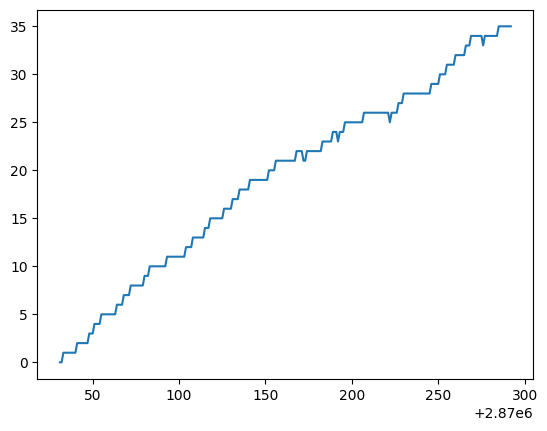

In [10]:
df_data['word_count'].plot()


In [14]:

std_scaler=StandardScaler()

word_count=df_data['word_count'].values


In [15]:
x_word_count=np.arange(len(word_count)).reshape(-1,1)

regr_wc = make_pipeline(StandardScaler(), svm.SVR(kernel='linear',C=100,
                                                    epsilon=10e-21))

regr_wc.fit(
    x_word_count,
    word_count)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=100, epsilon=1e-20, kernel='linear'))])

In [16]:
word_count_lin=regr_wc.predict(x_word_count)

word_count_flat=(word_count_lin-word_count).reshape(-1,1)

word_count_flat=std_scaler.fit_transform(word_count_flat)# aqui estandarizamos

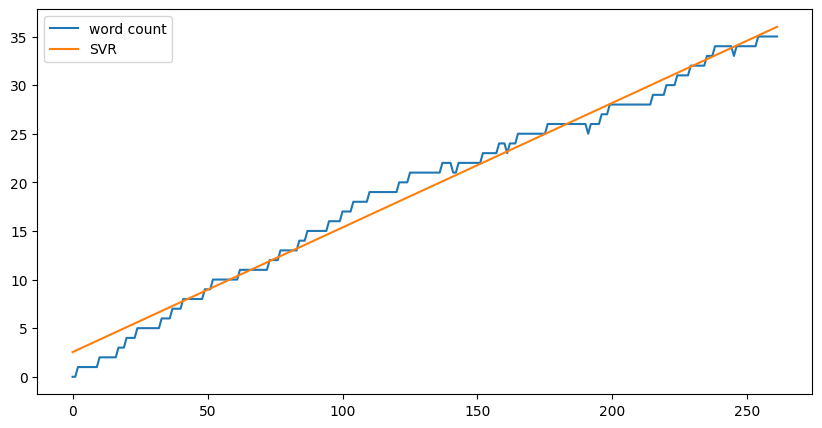

In [21]:
plt.figure(figsize=(10,5))
plt.plot(x_word_count,word_count, label='word count')
plt.plot(x_word_count,word_count_lin, label='SVR')
plt.legend()
plt.show()

In [22]:
  # hacemos la interpolacion

index_interp=np.floor(np.linspace(x_word_count[0], x_word_count[-1] ,
                                    int(len(x_word_count)*0.0075))).astype(int)

In [28]:
 int(len(x_word_count)*0.0075)

1

In [31]:
len(x_word_count)*0.0075

1.9649999999999999